✅ Balanced redacted image saved as redacted_balanced.png


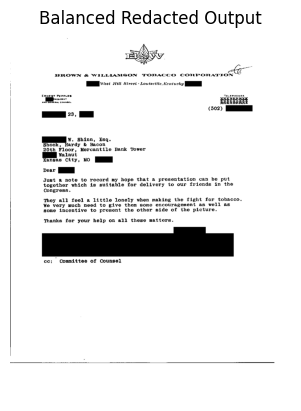

In [11]:
import cv2
import pytesseract
import spacy
import re
import matplotlib.pyplot as plt

# Load SpaCy
nlp = spacy.load("en_core_web_sm")

def detect_pii_word(word):
    """Detect PII category for a single word."""
    # Date formats
    date_pattern = r"(\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\b(?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[a-z]*\b|\d{4})"
    if re.search(date_pattern, word):
        return "DATE"

    # Signature keyword
    if re.search(r"(Signature|Sincerely|Cordially)", word, re.IGNORECASE):
        return "SIGNATURE"

    # Name detection with SpaCy
    doc = nlp(word)
    if any(ent.label_ == "PERSON" for ent in doc.ents):
        return "NAME"

    return None


def redact_image(image_path, save_path="redacted_balanced.png", pad=5):
    image = cv2.imread(image_path)

    # OCR at word level
    results = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    n_boxes = len(results["level"])
    skip_next = False

    for i in range(n_boxes):
        if skip_next:
            skip_next = False
            continue

        word = results["text"][i].strip()
        if not word:
            continue

        pii_type = detect_pii_word(word)

        if pii_type in ["NAME", "DATE"]:
            x, y, w, h = (
                results["left"][i],
                results["top"][i],
                results["width"][i],
                results["height"][i],
            )
            cv2.rectangle(
                image, (x - pad, y - pad), (x + w + pad, y + h + pad), (0, 0, 0), -1
            )

        if pii_type == "SIGNATURE":
            # Redact this word
            x, y, w, h = (
                results["left"][i],
                results["top"][i],
                results["width"][i],
                results["height"][i],
            )
            cv2.rectangle(
                image, (x - pad, y - pad), (x + w + pad, y + h + pad), (0, 0, 0), -1
            )

            # Redact next low-confidence line (likely handwriting)
            line_id = results["line_num"][i]
            for j in range(i + 1, n_boxes):
                if results["line_num"][j] != line_id + 1:
                    break
                if int(results["conf"][j]) < 60:
                    x2, y2, w2, h2 = (
                        results["left"][j],
                        results["top"][j],
                        results["width"][j],
                        results["height"][j],
                    )
                    cv2.rectangle(
                        image,
                        (x2 - pad, y2 - pad),
                        (x2 + w2 + pad, y2 + h2 + pad),
                        (0, 0, 0),
                        -1,
                    )
            skip_next = True

    # Save & show
    cv2.imwrite(save_path, image)
    print(f"✅ Balanced redacted image saved as {save_path}")

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Balanced Redacted Output")
    plt.show()


# Run
redact_image("dataset/images/train/fsc51a00.png")


In [2]:
!pip install easyocr


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.9 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.9 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.9 MB 2.1 MB/s eta 0:00:02
   -------------- ------------------------- 1.0/2.9 MB 1.9 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.9 MB 1.9 MB/s eta 0:00:01
   ------------------ --------------------- 1.3/2.9 MB 1.5 MB/s eta 0:00:02
   --------------------- ------------------ 1.6/2.9 MB 1.3 MB/s eta 0:00:01
   -------------------------------- ------- 2.4/2.9 MB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 2.9/2.9 MB 1.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.9 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.9 MB 5.3 MB/s eta 0:00:03
   --- ------------------------------------ 1.0/12.9 MB 3.4 MB/s eta 0:00:04
   ---- --------------------


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
